In [1]:
from math import exp
import numpy as np
from gym import spaces
from collections import defaultdict
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import gym
import itertools
import time

In [2]:
# states is defined by the current level of the batterie and the time
# actions are defined by the charing rate (None, low, medium, high; 0-35)
alpha = [0.5, 0.3, 0.6, 0.2, 0.5, 0.8, 0.2, 0.1]
cap = 0 
cap_max = 80
p_mi = 0 
p_max = 35
p = 0
𝜇= 30
𝜎 = 5
penalty = -1000

In [3]:
def cost_func(t, p):
    '''
    This method returns the costs for charging
    @param t:  time
    @param p:  charging rate
    '''
    return alpha[t] * exp(p)

In [4]:
def power_consumed(𝜇= 30, 𝜎 = 5, n=1):
    '''
    This method returns power consumed by the taxi driver
    @param 𝜇: mean
    @param 𝜎: standard deviation
    @param n: number of random variables
    '''
    return int(np.random.normal(𝜇,𝜎,n)[0])

In [5]:
print(power_consumed())

28


In [6]:
class SmartCharging(gym.Env):
    def __init__(self, actions, cap_max, penalty, loading_rate):
        super(SmartCharging, self).__init__()
        
        self.action_space = spaces.Discrete(actions)
        
        self.observation_space = spaces.Dict({
            'cap': spaces.Discrete(cap_max+1),
            'time': spaces.Discrete(8)
        })
        
        self.state = {
            'cap': 0,
            'time': 0
        }
        self.done = False
        
    def reset(self):
        self.state = {
        #    # ensures all states get visited uniformly
            'cap' : np.random.randint(0, cap_max+1),
        #    #'cap' : 0,
            'time' : 0
        }
        #self.state['time'] = 0
        self.done = False
        return self.state
        
    def step(self,action):
        # translate action into kwh loaded in 15min
        loaded = loading_rate(action)
        reward = 0
        if loaded + self.state['cap'] > cap_max:
            #print("1")
            # if charing would exceed totally capacity cap is set to cap_max
            
            reward -= cost_func(self.state['time'], cap_max - cap)
            self.state['cap'] = cap_max
            self.state['time'] += 1
        else:
            reward -= cost_func(self.state['time'], loaded)
            
            self.state['cap'] += loaded
            self.state['time'] += 1
        if self.state['time'] == 8:
            # if the final stage is reached reset the state

            consumed = power_consumed()
            if self.state['cap'] - consumed > 0:
                
                #self.reset(self.state['cap'] - consumed)
                self.reset()
            else:
                self.reset()
                reward += penalty
            self.done = True
                
        return reward, self.done 

In [7]:
def plot_q_values(q_table):
    
    def get_Z(key):
        #return max(q_table[key])
        return np.average(q_table[key])
        
    # batterie level
    X = np.arange(cap_max +1)
    # time
    Y = np.arange(8)
    X_grid, Y_grid = np.meshgrid(X, Y)
    # max q-values (policy)
    Z = np.array([get_Z(key) for key in itertools.product(Y,X)]).reshape((8,cap_max+1))

    fig = plt.figure(figsize=(10, 10))

    # Add a 3D subplot
    #ax = [fig.add_subplot(1, 3, i, projection='3d') for i in range(1, 4)]
    ax = fig.add_subplot(111, projection='3d')
    
    ax.plot_surface(X_grid, Y_grid, Z, cmap='viridis')

    ax.view_init(elev=30, azim=45)

    ax.set_zlabel('max Q-value')
    ax.set_ylabel('Time')
    ax.set_xlabel('Batterie level')
    plt.tight_layout()
    plt.show()

In [8]:
def loading_rate(action):
    if action == 0:
        return 0
    elif action == 1:
        return 3
    elif action == 2:
        return 6
    elif action == 3:
        return 10

In [9]:
class MC_agent():

    def __init__(self, epsilon, alpha, action_space, env, epsilon_decay, epsilon_min):
        self.env = env
        self.q_table = defaultdict(lambda: np.zeros(action_space))
        self.q_table_count = defaultdict(lambda: np.zeros(action_space))
        self.epsilon = epsilon
        self.alpha = alpha
        self.action_space = action_space
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

    def pick_action(self, state):
        if (state['time'], state['cap']) in self.q_table.keys():
            actions = self.q_table[(state['time'],state['cap'])] 
            return self.epsilon_greedy(actions)
        else:
            return env.action_space.sample()
            
    def epsilon_greedy(self, actions):
        
        action_space = self.action_space
        epsilon = self.epsilon
        
        policy_s = np.ones(action_space) * epsilon / action_space
        best_a = np.argmax(actions)
        policy_s[best_a] = 1 - epsilon + (epsilon / action_space)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return np.random.choice(np.arange(action_space), p=policy_s)

    def update_q_values(self, state, action, goal):
        time = state['time']
        cap = state['cap']

        self.q_table_count[time, cap][action] +=1
        alpha = 1 / np.square(self.q_table_count[time, cap][action])
        self.q_table[time, cap][action] = self.q_table[time, cap][action] + alpha * (goal - self.q_table[time, cap][action])
        #print(f" New q-value for state: {state} action: {action} and goal: {goal} : {self.q_table[time, cap][action]}")
        self.q_table[time, cap][action] = self.q_table[time, cap][action] + alpha * (goal - self.q_table[time, cap][action])
        

In [10]:
env = SmartCharging(4,cap_max, penalty, loading_rate)
agent = MC_agent(epsilon=0.1, 
                 alpha= 0.01, 
                 action_space= 4, 
                 env=env, 
                 epsilon_decay= 0.999, 
                 epsilon_min = 0.01)

In [11]:
start_time = time.time()
for i in range(300000):
    state = env.reset()
    episode = []
    rate = 0
    done = False
    # create episode
    while not done:
        # pick action
        action = agent.pick_action(state)
        #print(f"Currently in state: {state}")
        #print(f"Agent took action: {action}")
        # receive reward
        old_state = dict(state)
        reward, done = env.step(action)
        #print(f"And received reward: {reward}")
        # add the reward, state and action to the episode
        episode.append((old_state, action, reward))
        # update state
        state = env.state

    goal = 0
    # go through the episode from the end
    for state, action, goal in reversed(episode):
        goal += reward
        #print(state)
        agent.update_q_values(
            state, 
            action, 
            goal
        )
end_time = time.time()
print(f"Trainingtime took: {(end_time-start_time)/60} minuts")   

Trainingtime took: 1.794160548845927 minuts


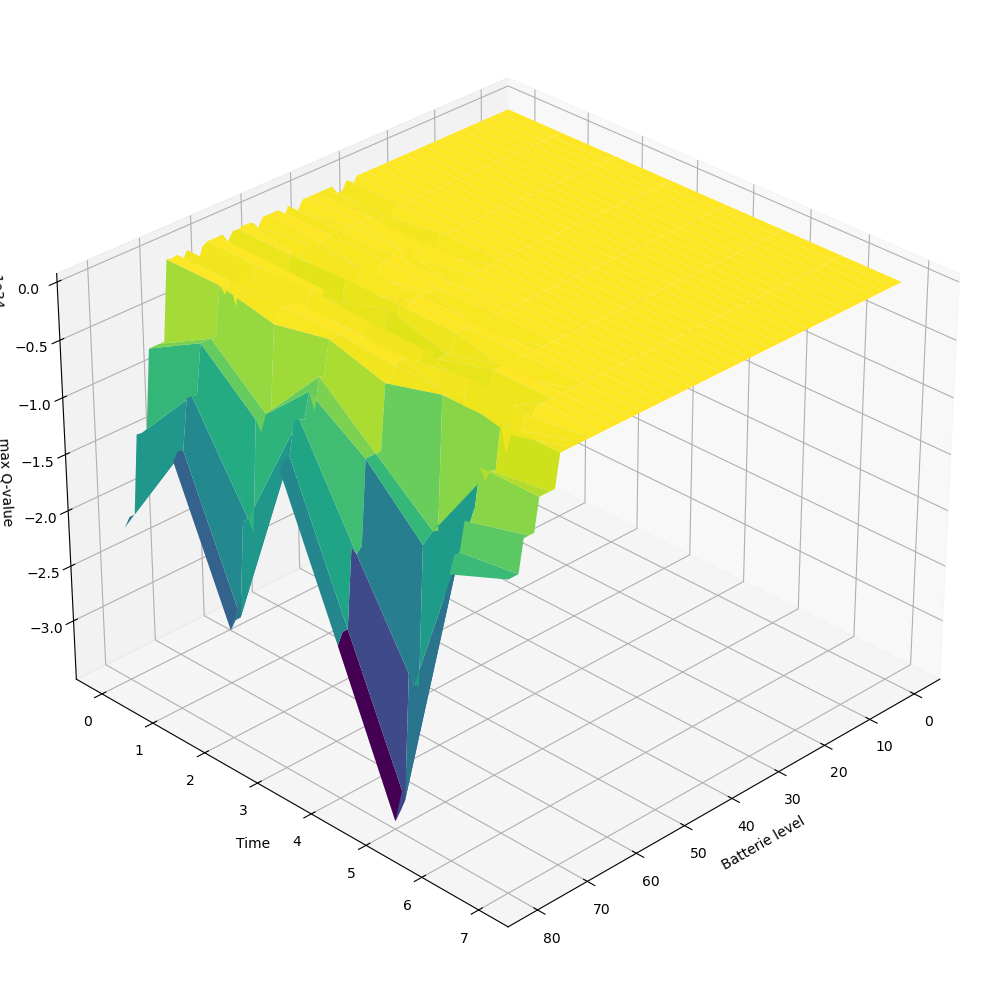

In [12]:
plot_q_values(agent.q_table)

In [13]:
print(agent.q_table)

defaultdict(<function MC_agent.__init__.<locals>.<lambda> at 0x7f95b17a5ca0>, {(7, 23): array([-2000.2       , -2004.01710738,  -905.94109711, -4405.29315896]), (6, 20): array([ -744.8477141 , -1597.37047848,  -224.59675407, -5282.15147525]), (5, 20): array([ -2203.44657948,  -1016.16842954,   -474.25103093, -19823.81921533]), (4, 17): array([ -1441.98924469,  -1323.49214822,   -506.65986621, -11047.49476845]), (3, 11): array([-1006.04380017,  -780.39255829, -2283.33233818, -4445.63603831]), (2, 5): array([ -1040.94287935,   -235.72753484,  -2444.70385558, -13256.22235623]), (1, 5): array([-1266.05738359,  -490.90783444,  -965.00147745, -6609.94829213]), (0, 2): array([  -960.59380905,  -1377.15268288,   -332.53142421, -12225.59236528]), (7, 42): array([-1.01871852e+03, -4.01912206e+00, -8.06857587e+01, -4.40529316e+03]), (6, 32): array([ -544.76453883, -1129.82880129,  -167.42947222, -4407.30171265]), (5, 32): array([  -224.60665287,    -56.88513667,  -1974.7529694 , -17623.18118954])

In [14]:
agent.q_table[(0,9)]

array([ -1419.53448866,  -1249.91021166,   -204.53395951, -12237.81813209])

In [15]:
agent.q_table[(0,80)]

array([-2.90023411e+29, -2.77031119e+34, -2.77031119e+34, -3.06865240e+34])